In [ ]:
# The first file will import the key data required for the study. 
# FLUXNET data is imported along with additional information on
# the sites. 

### Sources ###

# FLUXNET data: https://fluxnet.org
# Additional site data: https://fluxnet.org/sites/site-list-and-pages/



In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from pyrealm import pmodel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [3]:
### Import the additional site informations 
### SITE_ID, SITE_NAME, LAT, LONG

site_key=pd.read_csv('/Users/abigailbase/PROJECT FILES/site_key.csv')

In [6]:
#Import the FLUXNET daily data for all sites

df=pd.read_csv('/Users/abigailbase/PROJECT FILES/FINAL DFs/final_df.csv')

In [22]:
### Assign hemisphere to the points in the df. Above the equator (0) 
### is Northern Hemisphere (NH) 


def assign_hemisphere(latitude):
    if LAT > 0:
        return "Northern Hemisphere" 
    elif LONG < 0:
        return "Southern Hemisphere"
    else:
        return "Equator"  # This handles the case where latitude is exactly 0

In [26]:
### Assign hemisphere to the points in site data 

site_key['hemisphere']=site_key['LAT'].apply(lambda x: 'NH' if x>=0 else 'SH')

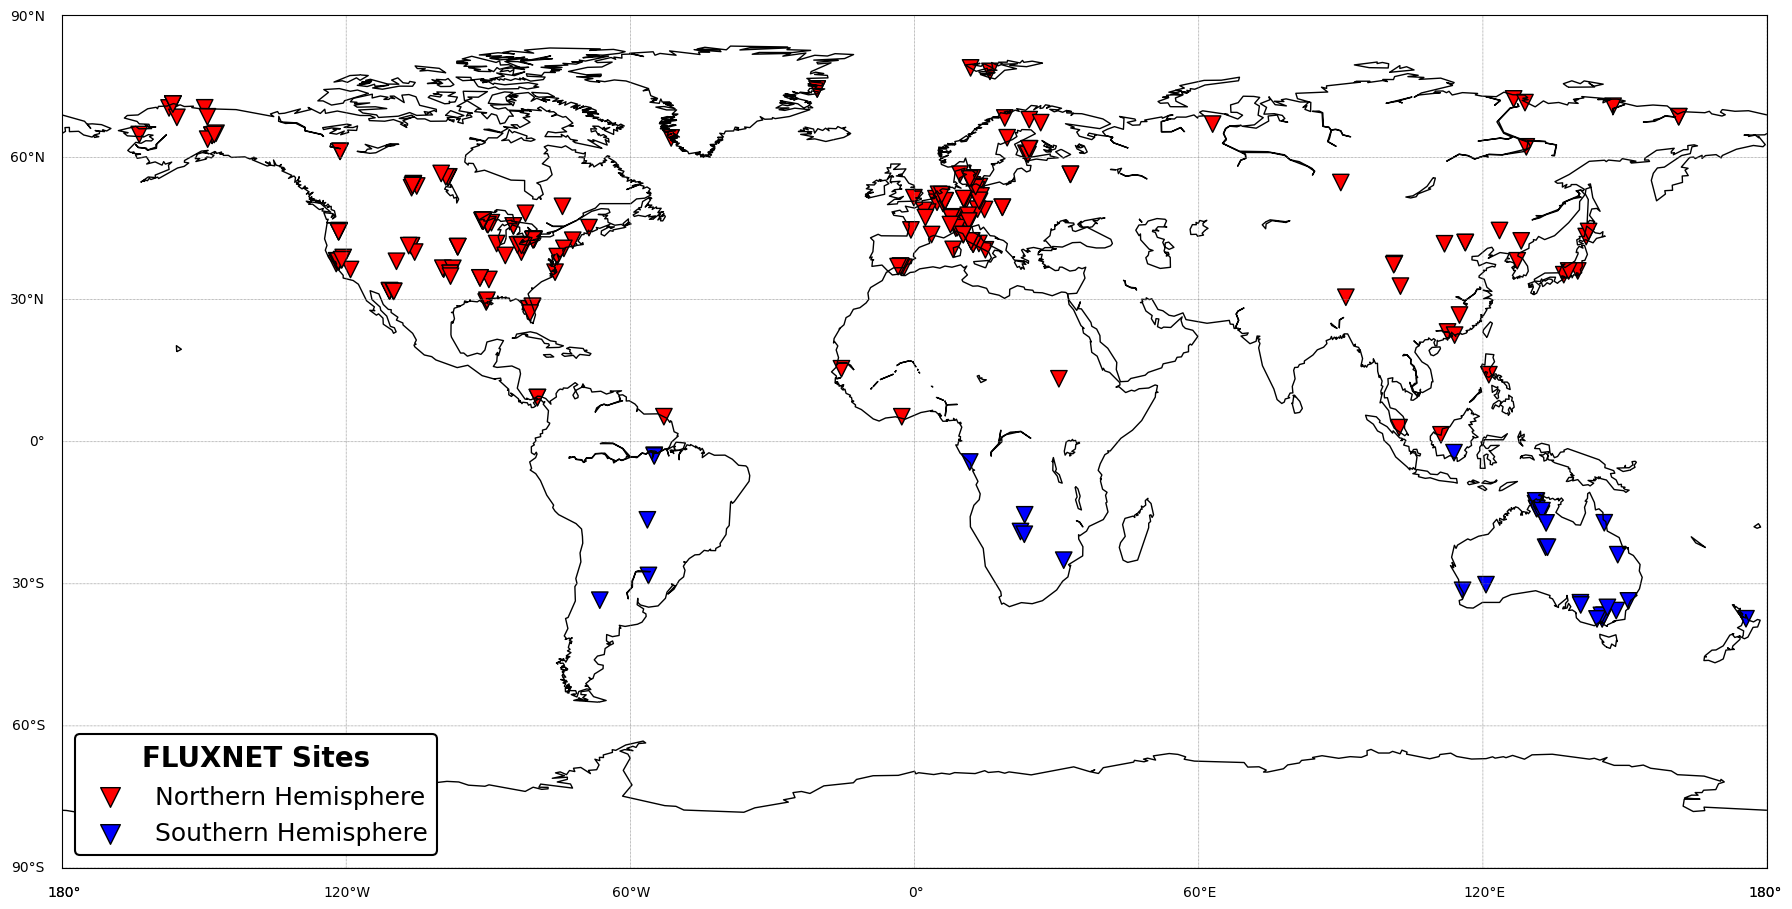

In [38]:
### Map of the sites ###


fig, ax = plt.subplots(figsize=(22, 14))

map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,
              llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=ax)

map.drawcoastlines()

# assign colors based on the hemisphere
colors = site_key['hemisphere'].map({
    'NH': 'red',
    'SH': 'blue'
})

# plot the sites
map.scatter(site_key['LONG'], site_key['LAT'], marker='v', c=colors, edgecolor='black', s=140)


# draw parallels and meridians
parallels = np.arange(-90., 91., 30.)
meridians = np.arange(-180., 181., 60.)
map.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5, color='grey')
map.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5, color='grey')


# legend
dummy_scatter_north = plt.scatter([], [], color='red', marker='v', s=200, edgecolors='black', label='Northern Hemisphere')
dummy_scatter_south = plt.scatter([], [], color='blue', marker='v', s=200, edgecolors='black', label='Southern Hemisphere')


legend = plt.legend(handles=[dummy_scatter_north, dummy_scatter_south], loc='lower left', fontsize=18)
legend.set_title("FLUXNET Sites", prop={'size': 20, 'weight': 'bold'})



frame = legend.get_frame()
frame.set_edgecolor('black')      
frame.set_linewidth(1.5)          
frame.set_alpha(1)                


plt.show()

lots of variables are alternative methods of calulating the key variables so will be put aside. 

In [98]:
### select the variables of interest ###


final_df=df[['TIMESTAMP','SITE_ID','TA_F','PA_F','VPD_F','P_F','WS_F',
            'PPFD_IN','PPFD_OUT','CO2_F_MDS','TS_F_MDS_1',
           'SWC_F_MDS_1','NEE_VUT_REF','GPP_DT_VUT_REF']]

In [99]:
final_df.head()

,TIMESTAMP,SITE_ID,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF
0,200101,CA-NS3,-15.366,98.150,0.709,0.268,1.872,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.308477,1.01440
1,200102,CA-NS3,-21.444,98.641,0.693,0.130,1.710,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.313358,2.01791
2,200103,CA-NS3,-9.496,98.429,1.166,0.333,1.835,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.310358,2.86919
3,200104,CA-NS3,-0.423,98.305,2.992,0.204,1.902,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.310643,4.16827
4,200105,CA-NS3,7.696,97.925,4.874,0.911,2.283,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.308477,4.34089


In [100]:
final_df['TIMESTAMP'].dtype #check data type = int64

dtype('int64')

In [101]:
### investigate the dates to see the format

print(final_df['TIMESTAMP'].unique().tolist())


[200101, 200102, 200103, 200104, 200105, 200106, 200107, 200108, 200109, 200110, 200111, 200112, 200201, 200202, 200203, 200204, 200205, 200206, 200207, 200208, 200209, 200210, 200211, 200212, 200301, 200302, 200303, 200304, 200305, 200306, 200307, 200308, 200309, 200310, 200311, 200312, 200401, 200402, 200403, 200404, 200405, 200406, 200407, 200408, 200409, 200410, 200411, 200412, 200501, 200502, 200503, 200504, 200505, 200506, 200507, 200508, 200509, 200510, 200511, 200512, 20010101, 20010102, 20010103, 20010104, 20010105, 20010106, 20010107, 20010108, 20010109, 20010110, 20010111, 20010112, 20010113, 20010114, 20010115, 20010116, 20010117, 20010118, 20010119, 20010120, 20010121, 20010122, 20010123, 20010124, 20010125, 20010126, 20010127, 20010128, 20010129, 20010130, 20010131, 20010201, 20010202, 20010203, 20010204, 20010205, 20010206, 20010207, 20010208, 20010209, 20010210, 20010211, 20010212, 20010213, 20010214, 20010215, 20010216, 20010217, 20010218, 20010219, 20010220, 20010221,

In [102]:
### There were datapoints which had the format YYYY%MM% so these
### were seperated out 

### seperate the data into 2 dfs for the differing datatime format 

def identify_format(date_str):
    if len(date_str) == 8:  #YYYY%MM%DD 
        return 'full_date'
    elif len(date_str) == 6:  #YYYY%MM 
        return 'month_year'
    else:
        return 'invalid'

In [103]:
date_df=final_df.copy()

In [104]:
date_df['TIMESTAMP'] = date_df['TIMESTAMP'].astype(str) #convert the date to string

In [105]:
date_df['TIMESTAMP']

dtype('O')

In [106]:
#create dummy column to flag the date type

date_df['date_type']=date_df['TIMESTAMP'].apply(identify_format)

In [107]:
full_date=date_df[date_df['date_type']=='full_date'] #YYYY%MM%DD

In [108]:
month_year=date_df[date_df['date_type']=='month_year'] #YYYY%MM

In [109]:
full_date.head()

,TIMESTAMP,SITE_ID,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF,date_type
60,20010101,CA-NS3,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625,full_date
61,20010102,CA-NS3,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820,full_date
62,20010103,CA-NS3,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700,full_date
63,20010104,CA-NS3,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478,full_date
64,20010105,CA-NS3,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661,full_date


In [110]:
full_date=full_date.drop(columns='date_type') #drop the dummy col

In [112]:
full_date['TIMESTAMP']=full_date['TIMESTAMP'].astype(int) #convert date to integer

In [114]:
full_date['TIMESTAMP'].dtype

dtype('int64')

In [116]:
### convert the date to pandas datetime 

full_date['TIMESTAMP'] = pd.to_datetime(full_date['TIMESTAMP'], format='%Y%m%d')


In [117]:
full_date['TIMESTAMP'].dtype

dtype('<M8[ns]')

In [118]:
### extract the year, month and day for full_date

full_date.loc[:, 'YEAR'] = full_date['TIMESTAMP'].dt.year


In [119]:
full_date.loc[:, 'MONTH'] = full_date['TIMESTAMP'].dt.month

In [120]:
full_date.loc[:, 'DAY'] = full_date['TIMESTAMP'].dt.day

In [121]:
### drop the timestamp column

full_date=full_date.drop(columns='TIMESTAMP') 

In [56]:
full_date.isna().sum() #No missing values in each column

TA_F               28488
PA_F               28488
VPD_F              28488
P_F                28488
WS_F               28488
PPFD_IN            91679
PPFD_OUT          326170
CO2_F_MDS          28488
TS_F_MDS_1         50403
SWC_F_MDS_1       121991
NEE_VUT_REF        28488
GPP_DT_VUT_REF     28488
YEAR                   0
MONTH                  0
DAY                    0
dtype: int64

In [ ]:
print(full_date.shape) #

In [123]:
# now the final df with the timestamp seperated out as year, month, day is saved
# and will be imported into the next file. 


full_date.to_csv('/Users/abigailbase/PROJECT FILES/FINAL DFs/full_date.csv',index=False)